## Using nestpy to plot NEST predictions and analyze data
A tutorial by Chloe Liebenthal (Rice University Astroparticle Group), November 2020

This tutorial will introduce you to the basics of plotting NEST curves, as well as some data utility functions that allow you to select datasets and compare them to the predictions made by NEST curves. These functions are also very useful in analyzing and comparing data.

### What is NEST?

NEST stands for Noble Element Simulation Technique. It is a C++ package that allows users to simulate various processes in noble elements, such as scintillation, ionization, and electroluminescence. Modelling these processes is very useful for various fields of particle physics research, such as dark matter detectors (including the XENON experiment), double beta decay searches, and radiation detection. It is particularly usefull for loe-energy nuclear recoils, such as the ones we'd expect from dark matter, so it is a very useful tool for our search!

Right now, NEST is able to model these various processes in all three phases of xenon- solid, liquid, and gas- and other noble elements, like argon, are modeled by NEST as well. Another key feature of NEST is that it allows users to change the parameters of the detector used in creating NEST's predictions. By using information about a preexisting detector or creating a custom one, users can take variables like temperature, pressure, efficiency and electric field variations into account for their predictions. 

#### How can NEST's predictions help me?

NEST's predictions are very useful as a supplement for experimental data. It can generate predictions for an experiment's results before the experiment takes place, which can be very helpful in formulating hypotheses and getting a general idea of how the experiment might turn out. Then, after it takes place, comparing the data to NEST again can indicate which data is anomalous compared to the predictions, prompting researchers to take another look at that data to see what factors may have caused the discrepancy. 

#### What is nestpy?

nestpy is a python binding for the NEST library, so it can be accessed through python instead of C++. Simply importing the nestpy module will give you complete access to NEST's simulations!

### Plotting yields with nestpy

Let's take a look at how we can use some of nestpy's simplest functions to create and plot useful predictions. In this case, we're going to look at the relationship between the recoil energy and the charge and light yields present during a nuclear recoil event.

Recoil energy refers to the energy level of the collision when an outside particle hits a xenon particle inside the detector. Charge and light yields respectively refer to the amount of electrons and photons that are released by the collision.

First, we'll need to import a few python modules. In addition to nestpy, numpy is necessary for the mathematical functions we will use to generate our nestpy predictions. matplotlib will be used to create plots of the predictions.

In [1]:
import nestpy
import numpy as np
import matplotlib.pyplot as plt

Next, we need to start setting up the background information for the predictions we'll create. For this example, we'll load up the preexisting deector settings for XENON10. 

Then, we will define nc, which stands for 'NEST calculations', as the specific parameters of the calculations that NEST makes based on the XENON10 settings. This way, calling nc later on will tell our nestpy functions about these parameters.

In [2]:
detector = nestpy.DetectorExample_XENON10()
nc = nestpy.NESTcalc(detector)

Next, it's time to define the function that we'll use to calculate the yield predictions. These functions return an array (a format in which numpy allows us to store data) that stores various possible yield values. 

@np.vectorize at the beginning is what Python calls a decorator. This means that it is a line of code that 'decorates', or expands the scope, of the functions it modifies right underneath it. In this case, it means that the output of GetYieldsVectorized will be vectorized, which means it is outputted as an array.

GetYieldsVectorized is the function that generates this array. It does this by calling the built-in nc.GetYields() function from nestpy. However, in order to generate the proper kwargs (keyword arguments) for nc.GetYields(), another set of functions is necessary; PhotonYield() and ElectronYield() each call GetYieldsVectorized() with different kwargs based on yield type, generating yields for either electrons or photons.

In [13]:
@np.vectorize
def GetYieldsVectorized(yield_type, **kwargs):

    yield_object = nc.GetYields(**kwargs)
    return getattr(yield_object, yield_type)

def PhotonYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)
 
def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

The next function will use the yields generated by GetYieldsVectorized() to output a 

In [14]:
def nest_curve(field, yield_type):
    #yield_type can be Charge or Photon
    fields = np.asarray([field])
    energies = np.logspace(-1, 2, 1000,)
    energies = np.reshape(energies, (1000,1))
    energies = np.broadcast_to(energies, (len(energies), len(fields)))
    kwargs = {'energy': energies, 'drift_field': fields}
    yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies #yields/keV
    if yield_type == 'Light':
        yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (energies, yields)

In [15]:
# Figure parameters common throughout all plots
version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')

all_fields = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [16]:
def predict_yields(fields, yield_type, savefig=False):
    '''
    Goal: to make a scatter plot of all the different yields at various energies.
    '''
    plt.figure(1, figsize=(11,7))
    subplot1 = plt.subplot(1,1,1)
    for field in fields:
        name = [field, "V/cm"]
        name = ' '.join(str(v) for v in name)
        subplot1.plot(nest_curve(field, yield_type)[0], nest_curve(field, yield_type)[1], label=name)

    title = [yield_type, 'Yields for Nuclear Recoils']
    title = ' '.join(str(v) for v in title)
    
    if yield_type == 'Charge':
        subtitle = [yield_type, 'Yield [n$_e$/keV]']
        plt.ylim(0, 9)
        subplot1.legend(loc='lower center', fontsize= 'large', ncol=3)
        subplot1.text(5, 3, version_textbox, bbox=bbox, horizontalalignment='right', fontsize='x-large')


    if yield_type == 'Light':
        subtitle = [yield_type, 'Yield [n$_y$/keV]']
        plt.ylim(0, 18)
        subplot1.legend(loc='upper left', fontsize= 'large', ncol=3)
        subplot1.text(1, 10, version_textbox, bbox=bbox, horizontalalignment='right', fontsize='x-large')


    subtitle = ' '.join(str(v) for v in subtitle)
    subplot1.set_xscale('log')
    subplot1.set_xlabel('Recoil Energy [keV]', fontsize =20)
    subplot1.set_title(title, fontsize = 24)
    subplot1.set_ylabel(subtitle, fontsize = 20) 
    subplot1.margins(0)
           
    if savefig:
        if yield_type == 'Charge':
            plt.savefig('nr_charge.png')    
        if yield_type == 'Light':
            plt.savefig('nr_light.png')   

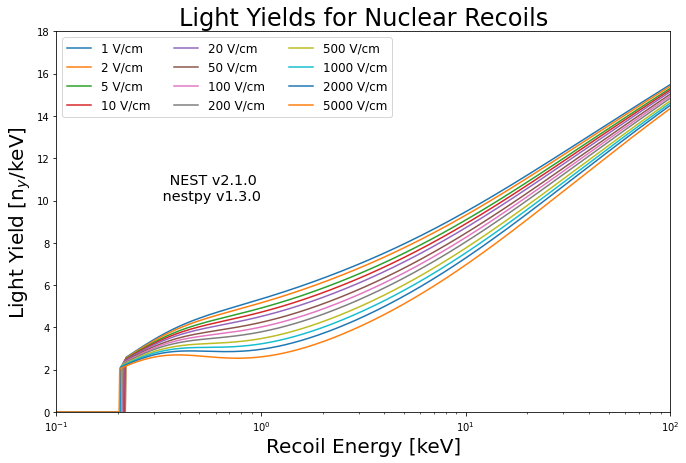

In [17]:
predict_yields(all_fields, 'Light')

#### Preparing our data

First, let's import all of the modules we're going to need. The json and glob modules are included because I have the datasets stored as JSONs, but depending on what filetype you use, you may not need them.

In [1]:
import json
import glob
import pandas as pd
import nestpy
import numpy as np
import matplotlib.pyplot as plt

Let's open our datasets as pandas dataframes. For this tutorial, I'll use one charge yield and one light yield nuclear recoil dataset. I saved them as JSONs, but you may have them stored differently.

#### Converting JSONS to pandas dataframes

In [29]:
charge_df = pd.read_json('charge/columbia_270.0_qy.json')
light_df = pd.read_json('light/xenon1t_82.0_ly.json')

dataframes = [charge_df, light_df]

If you want to load a lot of JSONs as dataframes at once, you can use the glob module to do it:

In [30]:
def load_all(pathname):
    '''
    This creates a list of dataframes created from JSONs.
    ''' 
    files = glob.glob(pathname)
#Input the pathname as wherever you have your JSONs stored.
    dfs = []
    for file in files:
        df = pd.read_json(file)
        dfs.append(df)
    return dfs

Next, we'll set up nestpy and write some functions to create NEST predictions in a format that can be easily plotted on a chart.

In nestpy, you can input various settings for the dark matter detector being used to generate predictions. In this case, we will use XENON10 for our predictions. @np.vectorize is used as a class method to make processing the NEST data easier, since there is a lot of it.

In [31]:
detector = nestpy.DetectorExample_XENON10()     
nc = nestpy.NESTcalc(detector)
@np.vectorize

#Now that we've created a detector environment in which to make our predictions, 
#it's time to to create functions to generate charge yields (in therms of electrons) and 
#light yields (in terms of photons).

def GetYieldsVectorized(interaction, yield_type, **kwargs):
    yield_object = nc.GetYields(interaction = interaction, **kwargs)
    return getattr(yield_object, yield_type) 

def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

def PhotonYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)

Now we can use those functions to generate datasets that can easily be graphed with matplotlib. 

The nest_curve functions takes a field strength measurement and a yield type (charge or light) and generates two lists: a list of recoil energies to graph on the x-axis, and a list of yield values for the y-axis.

The get_yields function is used to directly compare NEST predictions to real data. For each point in a given data set, a corresponding NEST yield prediction at the same field strength and recoil energy value is generated.

In [32]:
def nest_curve(field, yield_type):
    fields = np.asarray([field])
    energies = np.logspace(-1, 2, 1000,)
    energies = np.reshape(energies, (1000,1))
    energies = np.broadcast_to(energies, (len(energies), len(fields)))
    kwargs = {'energy': energies, 'drift_field': fields}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (energies, nest_yields)

def get_yields(energies, field, yield_type):
    kwargs = {'energy': energies, 'drift_field': field}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (nest_yields)

Now that we've written our NEST helper functions, we can create a function using matplotlib that generates a plot of our dataset, the NEST prediction curve, and a residuals subplot comparing NEST's prediction to the real data.

In [60]:
def plot_data(df, savefig=False):
    '''
    Goal: to make a scatter plot of all the different yields at various energies.
    '''
    #Uncomment these two lines if you want to include a textbox with the nestpy version:
    #version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
   # bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')
    
    #Create the plot
    fig, (subplot1, subplot2) = plt.subplots(2, figsize=(7,5), sharex = True, gridspec_kw={'height_ratios': [3, 1]})
     
    #Get data from the dataframe
    yields = df['yield'].tolist()
    energy = df['corrected_energy'].tolist()
    driftField = df['field'].iloc[0]
    yieldType = df['yield_type'].iloc[0]    
    name = df['identification'].iloc[0]
    error_flag = False
    if 'recoil_error' in list(df.columns):
        error_flag = True
        error = df['recoil_error'].tolist()

    subplot1.scatter(energy, yields, s=15, c= '#1f77b4',label= name)
    
    #If error information is included, create y-errorbars
    
    if error_flag == True:
        subplot1.errorbar(energy, yields, yerr = df['recoil_error'].tolist(), linewidth = 1, fmt = 'none')
    else:
        pass
        
    #plotting the nest curve
    nest_label = ['NEST: ', driftField, ' V/cm']
    nest_label = ''.join(str(v) for v in nest_label)
    curve = nest_curve(driftField, yieldType)
    subplot1.plot(curve[0], curve[1], 'c--', label= nest_label)
    
    #Limit the range of the plot, for readability
    max_x, min_x, max_y, min_y = max(energy), min(energy), max(yields), min(yields)
    subplot1.set_xlim([min_x - 5, max_x + 5])
    subplot1.set_ylim([min_y - .5, max_y + .5])
    
    #Add labels and a legend
    subplot1.legend(loc='upper left') 
    subplot1.legend(prop={'size': 9})
    subplot1.set_xlabel('Recoil Energy [keV]')
    if yieldType == 'charge':
        subplot1.set_ylabel('Charge Yield [e-/keVr]') 
    else:
        subplot1.set_ylabel('Light Yield [ph/keVr]')   
   
    #Creating a subplot with residuals: 
    nest_yvals = get_yields(energy, driftField, yieldType)
    if error_flag == True:
        resid_vals = [(x - y)/z for x, y, z in zip(yields, nest_yvals, error)]
    else:
        resid_vals = [x - y for x, y in zip(yields, nest_yvals)]
    residuals = dict(zip(energy, resid_vals))
    
    subplot2.scatter(list(residuals.keys()), list(residuals.values()))
    
    #Labels and a line at 0 for the residuals subplot
    subplot2.axhline(y=0, ls= '--')
    subplot2.set_ylabel('\u03C3 (deviation)')
    
    if any(abs(x) > 10 for x in residuals.values()):
        subplot2.set_yscale('symlog')
    
    #Grid lines
    subplot1.grid(b=True)
    subplot2.grid(b=True)
    
    plt.tight_layout()
    
    if savefig: 
        plt.savefig('qy.png') 

Now it's time to plot our datasets!

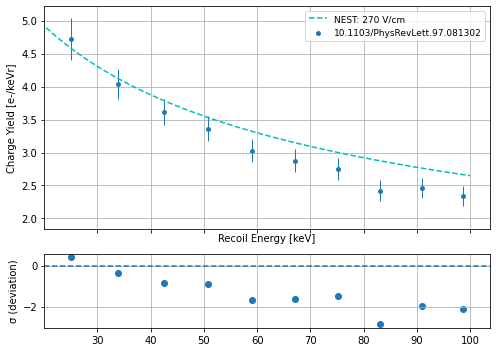

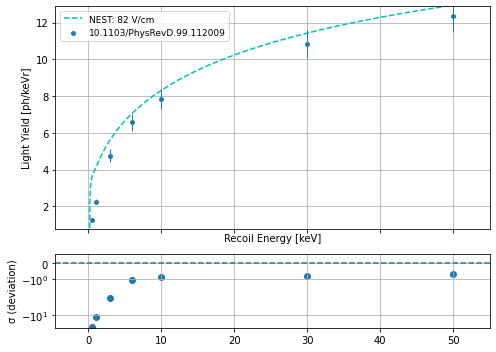

In [61]:
plot_data(charge_df)
plot_data(light_df)

I'm curious about how NEST's prediction accuracy changes with field strength, so I'll use the functions I've written to find out. First, I'll load all of the charge yield datasets. The plots wil have field strength on the x-axis and percent error on the y-axis.

In [9]:
charge_dfs = load_all('charge/*.json')
light_dfs = load_all('light/*.json')

In [46]:
def get_yield_diffs(dfs):
    yield_diffs = []
    for df in dfs:
        driftField = df['field'].iloc[0]
        yields = df['yield'].tolist()
        energy = df['corrected_energy'].tolist()
        yieldType = df['yield_type'].iloc[0]
        try:
            error = df['recoil_error'].tolist()
        except:
            pass
    
        nest_predictions = get_yields(energy, driftField, yieldType)   
        x = []
        
        for i in range(len(yields)):
            try:
                x.append([abs((yields[i] - nest_predictions[i])/nest_predictions[i]) * 100, error[i]])
            except:
                x.append([yields[i] - nest_predictions[i]])
        yield_diffs.append(x)  
    return yield_diffs

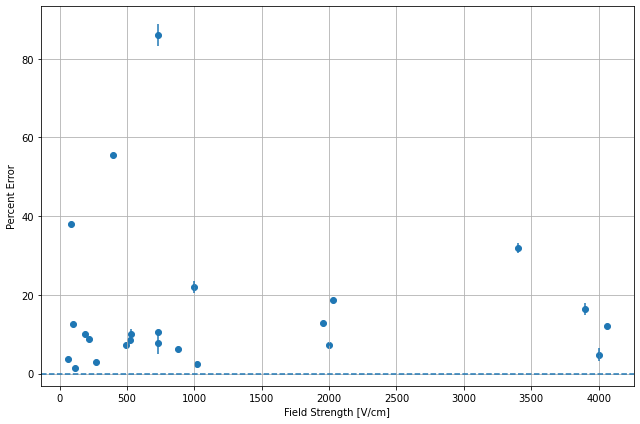

In [47]:
def plotdiffs(dfs):
    yield_diffs = get_yield_diffs(dfs)
    plt.figure(1, figsize=(9,6))
    subplot1 = plt.subplot(1,1,1)
    
    fields = []
    for df in dfs:
        fields.append(df['field'].iloc[0])   
    yvals = list(yield_diffs[i][0][0] for i in range(len(yield_diffs)))

    subplot1.scatter(fields, yvals)
    plt.errorbar(fields, yvals, yerr=list(yield_diffs[i][0][1] for i in range(len(yield_diffs))), fmt=',')
    subplot1.axhline(y=0, ls= '--')
    subplot1.set_ylabel('Percent Error')
    subplot1.set_xlabel('Field Strength [V/cm]')
    
    subplot1.grid(b=True)
    plt.tight_layout()
    
plotdiffs(charge_dfs)

Now I'll do the same thing for light yields.

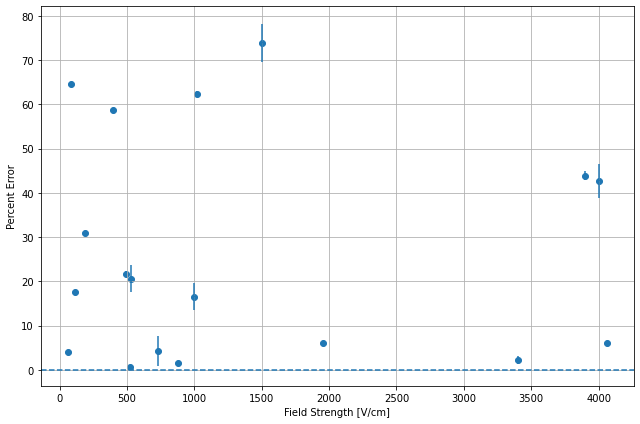

In [48]:
plotdiffs(light_dfs)